# Time Series Prediction

<hr/>

Predicting monthly sunspots

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h2>Load the data</h2>

In [2]:
dataset_path = './sunspots_data.csv'

data = pd.read_csv(dataset_path)
print("#samples:", len(data))
data.head()

#samples: 2820


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


<h2>Visualizations</h2>

In [61]:
def plot_data(y):
    plt.figure(figsize=(18, 5))
    plt.plot([i for i in range(0, len(y))], y)
    plt.show()
    
def compare_plot(predictions, target):
    t = [i for i in range(len(predictions))]
    plt.figure(figsize=(18, 5))
    plt.plot(t, target, 'r', label='Original')
    plt.plot(t, predictions, 'g', label='Predictions')
    plt.legend()
    plt.show()

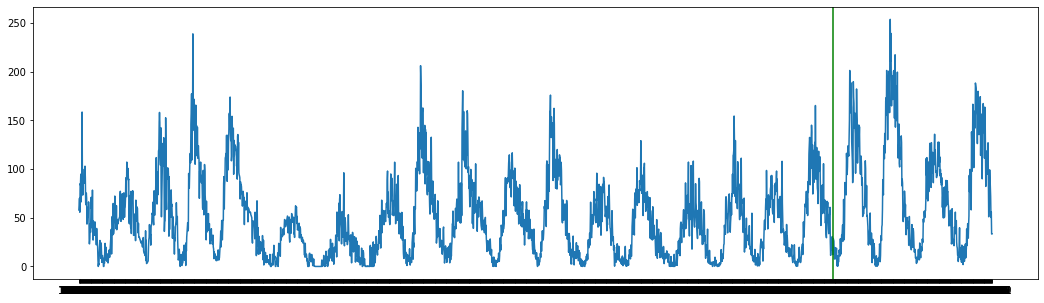

In [32]:
plt.figure(figsize=(18, 5))
plt.plot(data['Month'], data['Sunspots'])
# line separating train and validation set
plt.axvline(x='1943-01', color='g')
plt.show()

<h3>Baseline</h3>

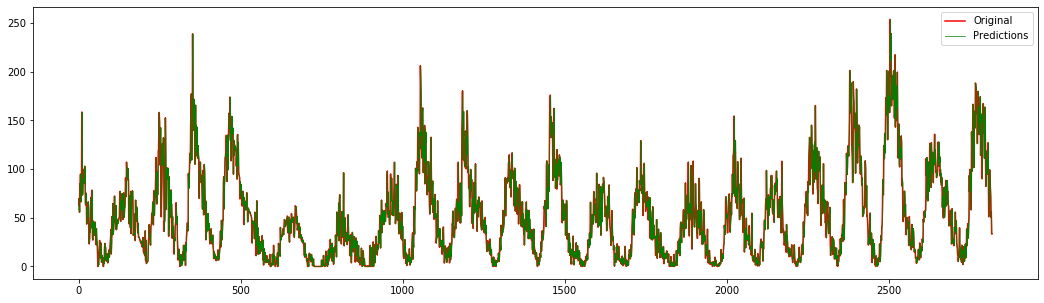

In [59]:
# creating a baseline by always predicting the previous day's value
predictions = data['Sunspots'][:-1]
compare_plot(predictions, data['Sunspots'][1:])

In [88]:
loss = 0
for target, pred in zip(data['Sunspots'][1:], predictions):
    loss += pow(target - pred, 2)

mse = loss / len(predictions)
rmse = pow(mse, 0.5)

print('MSE:', mse)
print('RMSE:', rmse)

MSE: 414.137725
RMSE: 20.35037407518594


<h3>Create dataset with windowing</h3>

In [18]:
window = 3
seq_len = 30
X, y = [], []

assert window <= seq_len

for i in range(0, len(data)-seq_len, window):
    spots_seq = []
    for spots in data.iloc[i:i+seq_len+1]['Sunspots']:
        spots_seq.append(spots)
    X.append(spots_seq[:-1])
    y.append(spots_seq[-1])
    
X, y = np.array(X), np.array(y)
print('Dataset generated')
print('Total no. of samples:', len(X))

# print(X, y)

Dataset generated
Total no. of samples: 930


In [19]:
# split into train and validation sets
train_size = 0.8
l = int(len(X) * train_size)
X_train, X_val, y_train, y_val = X[:l], X[l:], y[:l], y[l:]

print('No. of training samples:', len(X_train))
print('No. of validation samples:', len(X_val))
print('Fraction of validation samples wrt total:', round(len(X_val) / len(X_train), 2))

No. of training samples: 744
No. of validation samples: 186
Fraction of validation samples wrt total: 0.25


In [20]:
# normalize the data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
print('Dataset normalized')

Dataset normalized


In [21]:
# shuffle the data
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
print('Shuffled train and test set')

Shuffled train and test set


<h2>Model</h2>

In [22]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [49]:
# define the model, loss and optimizer, and print the summary
model = tf.keras.Sequential([
    tf.keras.layers.Input((seq_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mae'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 30, 40)            3520      
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                18688     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                3250      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 25,509
Trainable params: 25,509
Non-trainable params: 0
_________________________________________________________________


In [24]:
# reshape the data as required be LSTM
X_train = X_train.reshape(-1, seq_len, 1)
X_val = X_val.reshape(-1, seq_len, 1)

In [50]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=12)

Epoch 1/200
62/62 [==============================] - 2s 28ms/step - loss: 3290.1956 - mae: 43.8963 - val_loss: 8949.7344 - val_mae: 77.0049
Epoch 2/200
62/62 [==============================] - 1s 13ms/step - loss: 3254.3057 - mae: 43.6234 - val_loss: 8796.6777 - val_mae: 76.2358
Epoch 3/200
62/62 [==============================] - 1s 15ms/step - loss: 3153.4536 - mae: 42.8440 - val_loss: 8469.6416 - val_mae: 74.4652
Epoch 4/200
62/62 [==============================] - 1s 13ms/step - loss: 2960.9221 - mae: 41.2307 - val_loss: 8071.8120 - val_mae: 72.1264
Epoch 5/200
62/62 [==============================] - 1s 13ms/step - loss: 2728.5166 - mae: 38.9398 - val_loss: 7615.6289 - val_mae: 69.1025
Epoch 6/200
62/62 [==============================] - 1s 13ms/step - loss: 2451.0225 - mae: 35.6176 - val_loss: 7167.5371 - val_mae: 65.8888
Epoch 7/200
62/62 [==============================] - 1s 16ms/step - loss: 2235.5605 - mae: 33.7095 - val_loss: 6793.6855 - val_mae: 63.6164
Epoch 8/200
62/62 [=

62/62 [==============================] - 1s 13ms/step - loss: 291.7181 - mae: 11.9806 - val_loss: 1135.4161 - val_mae: 21.4716
Epoch 60/200
62/62 [==============================] - 1s 12ms/step - loss: 320.3682 - mae: 12.1510 - val_loss: 1116.8723 - val_mae: 21.2168
Epoch 61/200
62/62 [==============================] - 1s 12ms/step - loss: 302.7827 - mae: 12.0618 - val_loss: 1087.1628 - val_mae: 20.9408
Epoch 62/200
62/62 [==============================] - 1s 14ms/step - loss: 317.6137 - mae: 12.4251 - val_loss: 1063.0791 - val_mae: 20.8590
Epoch 63/200
62/62 [==============================] - 1s 14ms/step - loss: 288.8923 - mae: 11.9234 - val_loss: 1048.8740 - val_mae: 20.7042
Epoch 64/200
62/62 [==============================] - 1s 13ms/step - loss: 302.5124 - mae: 11.8368 - val_loss: 1030.1350 - val_mae: 20.4762
Epoch 65/200
62/62 [==============================] - 1s 15ms/step - loss: 288.8454 - mae: 11.8001 - val_loss: 1026.9304 - val_mae: 20.4925
Epoch 66/200
62/62 [=============

Epoch 118/200
62/62 [==============================] - 1s 13ms/step - loss: 245.5236 - mae: 11.1138 - val_loss: 597.3849 - val_mae: 16.5397
Epoch 119/200
62/62 [==============================] - 1s 12ms/step - loss: 232.3329 - mae: 11.1481 - val_loss: 566.9377 - val_mae: 15.9577
Epoch 120/200
62/62 [==============================] - 1s 16ms/step - loss: 217.2884 - mae: 10.8564 - val_loss: 549.5320 - val_mae: 15.8779
Epoch 121/200
62/62 [==============================] - 1s 13ms/step - loss: 239.6124 - mae: 11.1643 - val_loss: 595.0389 - val_mae: 16.4812
Epoch 122/200
62/62 [==============================] - 1s 14ms/step - loss: 233.5311 - mae: 11.0480 - val_loss: 560.0227 - val_mae: 15.9509
Epoch 123/200
62/62 [==============================] - 1s 13ms/step - loss: 219.9710 - mae: 10.7718 - val_loss: 553.5410 - val_mae: 15.9660
Epoch 124/200
62/62 [==============================] - 1s 12ms/step - loss: 256.6443 - mae: 11.4377 - val_loss: 554.6423 - val_mae: 16.0599
Epoch 125/200
62/62 

62/62 [==============================] - 1s 13ms/step - loss: 225.8655 - mae: 10.8821 - val_loss: 479.2215 - val_mae: 15.1001
Epoch 177/200
62/62 [==============================] - 1s 13ms/step - loss: 221.1137 - mae: 10.7456 - val_loss: 474.1378 - val_mae: 15.0325
Epoch 178/200
62/62 [==============================] - 1s 14ms/step - loss: 243.8501 - mae: 11.0986 - val_loss: 499.2252 - val_mae: 15.3644
Epoch 179/200
62/62 [==============================] - 1s 13ms/step - loss: 230.4973 - mae: 10.9212 - val_loss: 473.6571 - val_mae: 14.9819
Epoch 180/200
62/62 [==============================] - 1s 14ms/step - loss: 228.1655 - mae: 10.7950 - val_loss: 474.1756 - val_mae: 15.0287
Epoch 181/200
62/62 [==============================] - 1s 13ms/step - loss: 239.4432 - mae: 10.9381 - val_loss: 482.8057 - val_mae: 15.1370
Epoch 182/200
62/62 [==============================] - 1s 13ms/step - loss: 222.8236 - mae: 10.9140 - val_loss: 484.8377 - val_mae: 15.1056
Epoch 183/200
62/62 [=============

In [38]:
def plot_graphs(history, metric, start=0):
    plt.plot(history.history[metric][start:])
    plt.plot(history.history['val_'+metric][start:], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

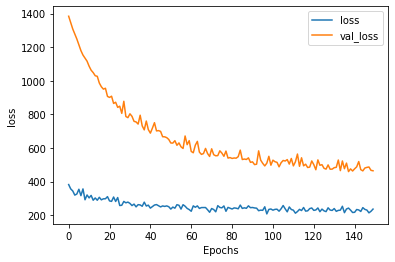

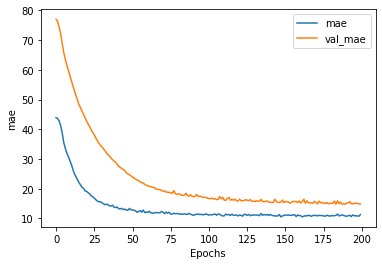

In [52]:
plot_graphs(history, 'loss', 50)
plot_graphs(history, 'mae')

<h3>Plotting the predictions for validation set against the ground truth</h3>

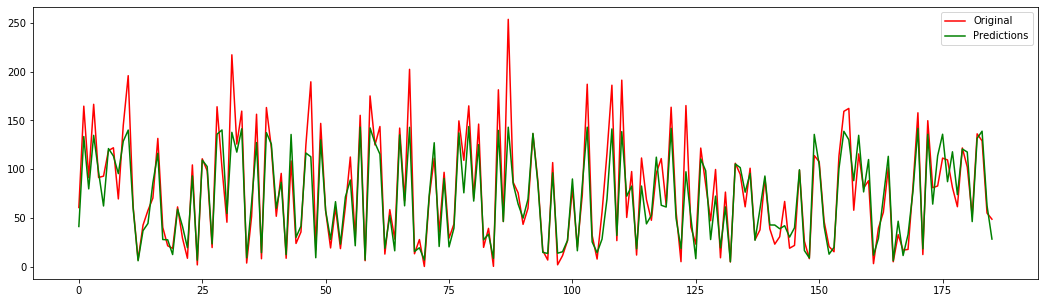

In [62]:
predictions = model.predict(X_val)
compare_plot(predictions, y_val)